# Image-captioning 

- gen the description of the image by using encoder-decoder model.

- Dataset : -> Flickr8K.

- Data-preprocesing : Need to create the vocab for text data and then into nums.(for image same as before).

- Model : -> Encoder : -> CNN(Resnet50) and BahdanauAttention + Decoder(LSTMs).


# Data 

In [13]:
#imports 
import pandas as pd
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transform 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image

# spacy tokens 

import spacy
spacy_eng = spacy.load("en_core_web_sm") # to tokenize the text data (captions)

In [14]:
class Vocabulary:
    def __init__(self,freq_threshold):
        
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
      
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
               
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
       
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [15]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
       
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
       
        if self.transform is not None:
            img = self.transform(img)
        
        
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [16]:
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [17]:
#exploring the data 

dataset =  FlickrDataset(
    root_dir = "/kaggle/input/flickr8k/Images",
    captions_file = "/kaggle/input/flickr8k/captions.txt",
    transform=transform
)

In [50]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 224, 224]), torch.Size([15]))

tensor([   1,   50,  134,   12,   79,  348, 1784,   34,  416,  133,   58, 2567,
        1474,    5,    2])
<SOS> two boys with wearing baseball caps are sticking out green stained tongues . <EOS> 

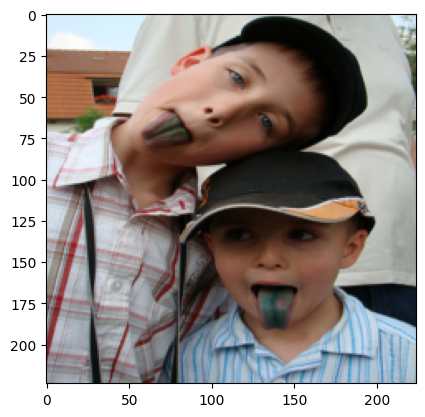

In [51]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [20]:
class CapsCollate:
   
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [31]:
import torch
from torch.utils.data import DataLoader, Subset

pad_idx = dataset.vocab.stoi["<PAD>"]
subset_indices = list(range(1000))
subset = Subset(dataset, subset_indices)

# Define DataLoader with the subset
BATCH_SIZE = 32
NUM_WORKER = 4
data_loader = DataLoader(
    dataset=subset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)


# Model 

The model consists two imp blocks i.e encoder and decoder.

### Encoder :


### Decoder : 

In [53]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    
        features = features.permute(0, 2, 3, 1)                          
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

In [54]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super().__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     
        w_ah = self.W(hidden_state) 
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) 
        
        attention_scores = self.A(combined_states)        
        attention_scores = attention_scores.squeeze(2)    
        
        
        alpha = F.softmax(attention_scores,dim=1)    #attention_weight      
        
        attention_weights = features * alpha.unsqueeze(2)  
        attention_weights = attention_weights.sum(dim=1)  
        
        return alpha,attention_weights

In [55]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        
        seq_length = len(captions[0]) - 1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
                
        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            
            preds[:, s] = output
            alphas[:, s] = alpha  
        
        return preds, alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  
        c = self.init_c(mean_encoder_out)
        return h, c


In [56]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


# Training

In [57]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [59]:

#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel
import os

def train(model, data_loader, criterion, optimizer, num_epochs, vocab_size, dataset):
    # two gpus
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = DataParallel(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # mixed precision(16-bit)
    scaler = GradScaler()

    print_every = 10
    best_loss = float('inf')
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for idx, (image, captions) in enumerate(data_loader):
            image, captions = image.to(device), captions.to(device)
            
            optimizer.zero_grad()
            
            #autocast for mixed precision
            with autocast():
                outputs, _ = model(image, captions)
                targets = captions[:, 1:]
                loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

            # scale the loss and call backward()
            scaler.scale(loss).backward()
            
            # unscale gradients and call optimizer.step()
            scaler.step(optimizer)
            
            # update the scaler
            scaler.update()
            
            running_loss += loss.item()
            
            
            _, predicted = outputs.max(2)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.numel()
            
            if (idx + 1) % print_every == 0:
                avg_loss = running_loss / print_every
                accuracy = correct_predictions / total_predictions
                print(f"Epoch: {epoch}/{num_epochs}, Batch: {idx+1}/{len(data_loader)}, Loss: {avg_loss:.5f}, Accuracy: {accuracy:.5f}")
                running_loss = 0.0
                correct_predictions = 0
                total_predictions = 0
        
        # Evaluate the model
        model.eval()
        eval_loss = 0.0
        eval_correct = 0
        eval_total = 0
        
        with torch.inference_mode():
            for image, captions in data_loader:
                image, captions = image.to(device), captions.to(device)
                with autocast():
                    outputs, _ = model(image, captions)
                    targets = captions[:, 1:]
                    loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
                eval_loss += loss.item()
                
                _, predicted = outputs.max(2)
                eval_correct += (predicted == targets).sum().item()
                eval_total += targets.numel()
        
        avg_eval_loss = eval_loss / len(data_loader)
        eval_accuracy = eval_correct / eval_total
        print(f"Epoch: {epoch}/{num_epochs}, Validation Loss: {avg_eval_loss:.5f}, Validation Accuracy: {eval_accuracy:.5f}")
        
        # save the model if it's the best so far
        if avg_eval_loss < best_loss:
            best_loss = avg_eval_loss
            save_checkpoint(model, optimizer, epoch, loss=best_loss, accuracy=eval_accuracy)
            print(f"w-model {epoch}")

def save_checkpoint(model, optimizer, epoch, loss, accuracy):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.module.state_dict() if isinstance(model, DataParallel) else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, 'good_model.pth')

In [61]:
num_epochs = 100

train(model, data_loader, criterion, optimizer, num_epochs, vocab_size, dataset)

Using 2 GPUs
Epoch: 1/100, Batch: 10/32, Loss: 6.87126, Accuracy: 0.06967



KeyboardInterrupt



In [45]:
torch.save(model.state_dict(), '/kaggle/working/model.pth')


In [46]:
model.load_state_dict(torch.load('/kaggle/working/model.pth'))


<All keys matched successfully>

# Inference 

In [44]:
checkpoint = torch.load("/kaggle/working/good_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [52]:
import torch
from torchvision import transforms
from PIL import Image

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
embed_size = 300
vocab_size = len(dataset.vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
drop_prob = 0.3

model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    drop_prob=drop_prob
).to(device)

# Load the pre-trained model weights
model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location=device))
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def predict_caption(image_path, model, dataset, max_len=50):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    # Encode the image
    features = model.encoder(image)
    
    # Initialize the hidden and cell states
    h, c = model.decoder.init_hidden_state(features)
    
    # Start the caption with the <SOS> token
    word = torch.tensor([dataset.vocab.stoi["<SOS>"]]).to(device)
    embeds = model.decoder.embedding(word)
    
    captions = []
    alphas = []
    
    for _ in range(max_len):
        alpha, context = model.decoder.attention(features, h)
        alphas.append(alpha.cpu().detach().numpy())
        
        lstm_input = torch.cat((embeds.squeeze(1), context), dim=1)
        h, c = model.decoder.lstm_cell(lstm_input, (h, c))
        
        output = model.decoder.fcn(model.decoder.drop(h))
        predicted_word_idx = output.argmax(dim=1)
        
        captions.append(predicted_word_idx.item())
        
        if dataset.vocab.itos[predicted_word_idx.item()] == "<EOS>":
            break
        
        embeds = model.decoder.embedding(predicted_word_idx.unsqueeze(0))
    
    # Convert word indices to words
    caption = [dataset.vocab.itos[idx] for idx in captions]
    return " ".join(caption)

# Test the inference
image_path = "/kaggle/input/tes0-2/Screenshot 2024-08-19 at 7.50.57PM (2).png" 
caption = predict_caption(image_path, model, dataset)
print("Generated Caption:", caption)


Generated Caption: a man holds a red shirt and a <UNK> hat . <EOS>


# Conclusion 